In [1]:
#importing the necessary modules.
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import nvidia.dali.fn as fn
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools

Let's define some volumetric test data and utilities for displaying it.

In [2]:
import cv2
#transform parameters are hard-coded, but axis, angle and matrix arguments can be specified as CPU tensors.
#tx,ty are transalations vectors
def centered_scale(in_size, out_size, scale):
    tx = (in_size[1]-out_size[1]/scale)/2
    ty = (in_size[0]-out_size[0]/scale)/2
    return np.array([[1/scale, 0, tx],
                     [0, 1/scale, ty]])

def project_volume(volume, out_size, eye_z, fovx = 90, zstep = 0.25):
    out_shape = out_size
    if len(volume.shape) > 3 and volume.shape[-1] > 1:
        out_shape += [volume.shape[-1]]
    output = np.zeros(out_shape)
    in_size = volume.shape[1:3]
    fovx_z = math.tan(math.radians(fovx/2)) * volume.shape[2] / out_size[1]

    def project_slice(volume, plane_z):
        plane_index = int(plane_z)
        volume_slice = volume[plane_index]
        scale = volume_slice.shape[1] / fov_w
        M = centered_scale(in_size, out_size, scale)
        return cv2.warpAffine(volume_slice, M,
                                dsize = (out_size[1], out_size[0]),
                                flags = cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR)

    for plane_z in np.arange(0, volume.shape[0], zstep):
        z = plane_z - eye_z
        fov_w = z * fovx_z
        z0 = np.clip(math.floor(plane_z), 0, volume.shape[0]-1)
        z1 = np.clip(math.ceil(plane_z), 0, volume.shape[0]-1)
        projected_slice = project_slice(volume, z0)
        # trilinear interpolation
        if z1 != z0:
            slice1 = project_slice(volume, z1)
            q = (plane_z - np.floor(plane_z))
            projected_slice = (projected_slice * (1-q) + slice1*q).astype(np.uint8)

        output += projected_slice

    return output

def perspective(volume, max_size):
    window_size = 300
    (h, w) = volume.shape[1:3]
    if h > w:
        w = window_size * w // h
        h = window_size
    else:
        h = window_size * h // w
        w = window_size
    return (project_volume(volume, [h,w], -volume.shape[2]) * (1 / 255.0))

import matplotlib.gridspec as gridspec

def draw_volume(volume, title):
    captions = ["XY middle slice", "ZY middle slice", "XZ middle slice", "perspective"]
    shape = volume.shape
    persp = perspective(volume, 300)
    persp *= 1.0/persp.max()
    persp = persp.clip(0, 1)
    
    axes = (1,0,2) if len(shape) > 3 else (1,0)
    images = [volume[shape[0]//2,:,:],\
              volume[:,:,shape[2]//2].transpose(axes),\
              volume[:,shape[1]//2,:],\
              persp]
    for i in range(len(images)):
        if len(images[i].shape) == 3 and images[i].shape[2] == 1:
            images[i] = images[i][:,:,0]

    fig = plt.figure(figsize = (16,18))
    plt.suptitle(title, fontsize=18)
    columns = 2
    rows = int(math.ceil(len(images) / columns))
    gs = gridspec.GridSpec(rows, columns)

    for i in range(len(images)):
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title(captions[i])
        plt.imshow(images[i], origin='lower')

In [3]:
import os 
os.environ['DALI_EXTRA_PATH']='../DALI_extra'

In [10]:
import os
#loading the dataset 
test_data_root = os.environ['DALI_EXTRA_PATH']
base_dir = os.path.join(test_data_root, 'db', '3D', 'MRI', 'Knee', 'Jpegs', 'STU00001')

def LoadData(dir):
    imgs = []
    i = 0
    path = os.path.join(base_dir, dir, "%i.jpg")
    while True:
        img = cv2.imread(path%i, cv2.IMREAD_GRAYSCALE)
        if img is None:
            break
        i += 1
        imgs.append(img[::-1,:,np.newaxis])
    a = (np.stack(imgs, axis=0) / 255).astype(np.float32)
    return a

def GetData():
    return [LoadData('SER00008')]



In [11]:
#Building the DALI pipeline
pipe = Pipeline(batch_size = 1, num_threads = 3, device_id = 0, exec_pipelined = True, exec_async = True)
with pipe:
    data = fn.external_source(source=GetData, device="gpu", layout="DHWC")

    resized = fn.resize(
            data,
            resize_z = 224,
            mode = "stretch",  # scale only Z axis
            interp_type = types.INTERP_LANCZOS3
        )
            
    angle = fn.random.uniform(range=(-20, 20), seed=123)
    axis = fn.random.uniform(range=(-1,1), shape=[3])
    rotated = fn.rotate(
            resized,
            angle = angle,
            axis = axis,
            interp_type = types.INTERP_LINEAR,
            fill_value = 0  # force out-of-bounds pixels to 0
        )

    warped = fn.warp_affine(
            resized,
            size = (200, 320, 320),
            matrix = (
                1, 1, 0,   -180,
                0, 1, 0.2, -20,
                0, 0, 1,   10
            ),
            interp_type = types.INTERP_LINEAR,
            fill_value = 0  # force out-of-bounds pixels to 0
        )

    pipe.set_outputs(data, resized, rotated, warped, axis, angle)

pipe.build()


In [12]:
pipe_out = pipe.run()

## Example Output

The output is displayed as three middle slices (XY, ZY and XZ) and a perspective projection.
The perspective projection is obtained by integrating intensities along rays corresponding to pixels.

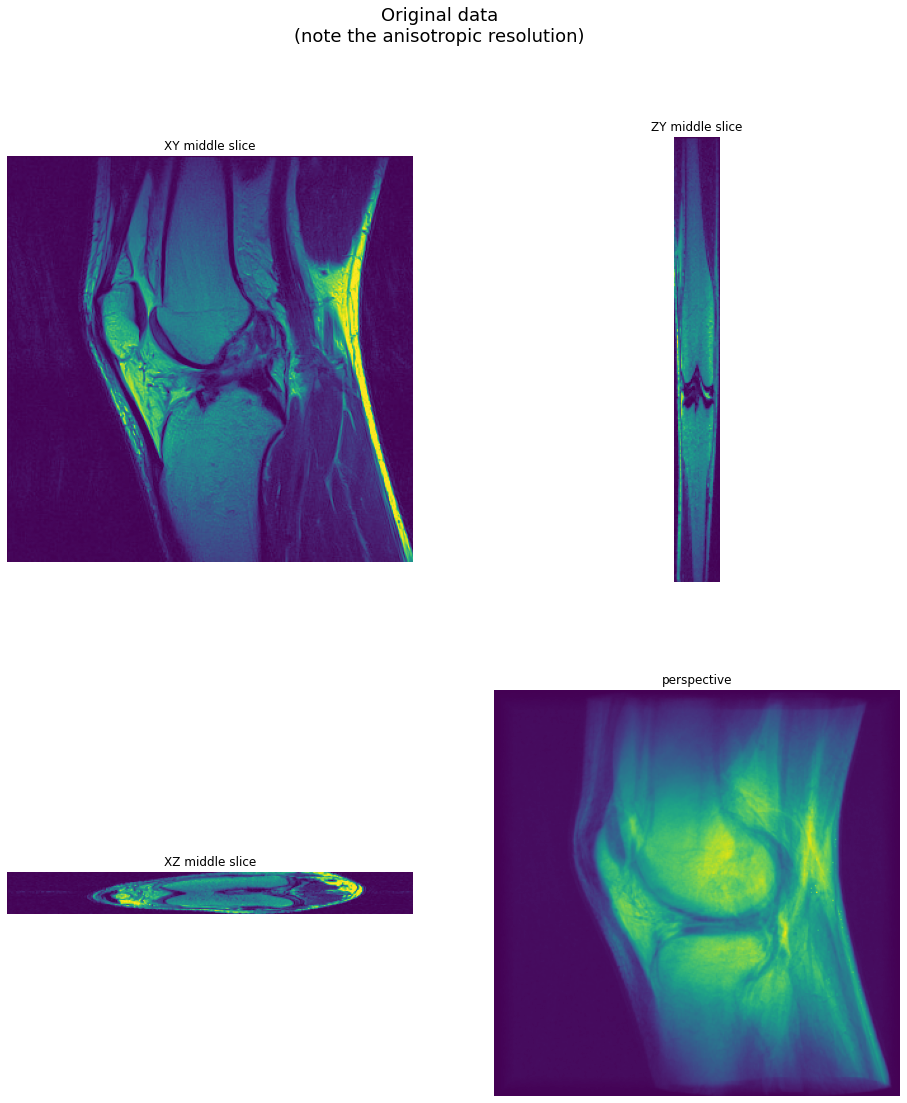

In [13]:
draw_volume(pipe_out[0].as_cpu().at(0), "Original data\n(note the anisotropic resolution)")

### Result: Resize



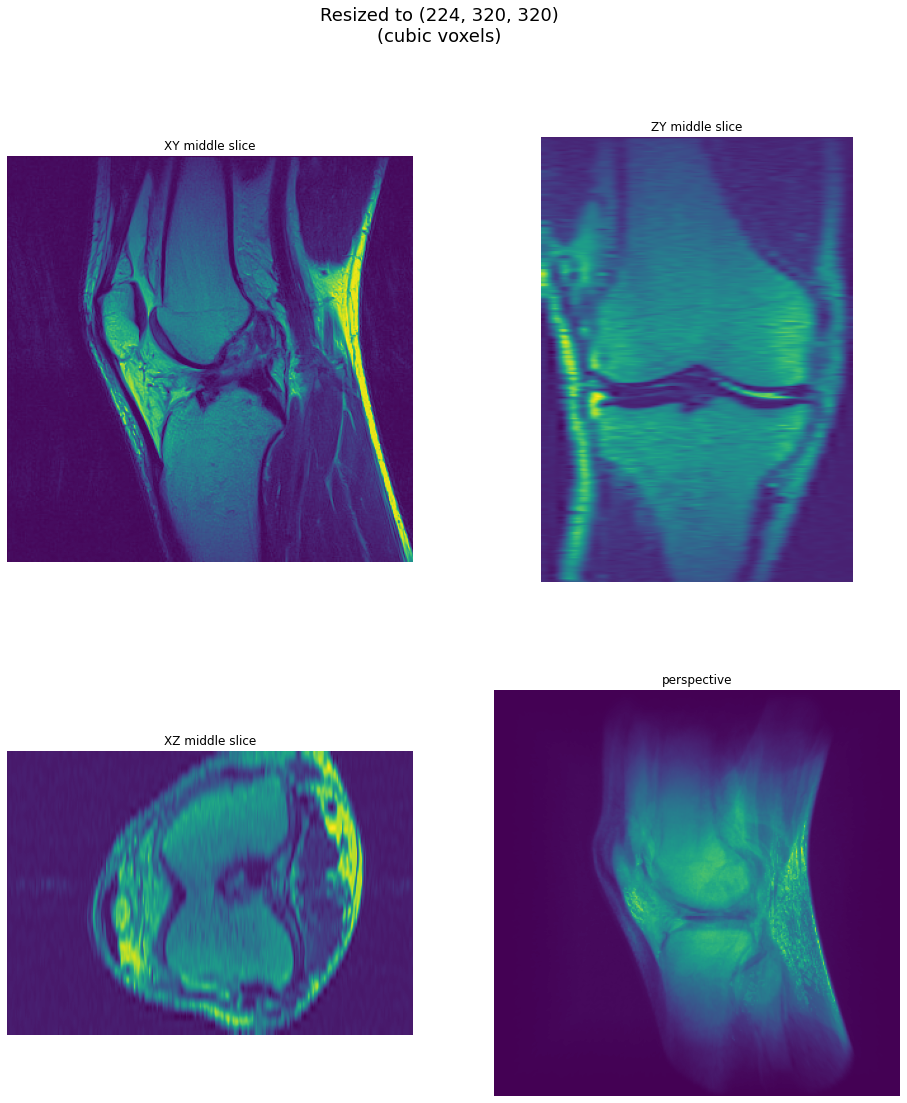

In [16]:
vol = pipe_out[1].as_cpu().at(0)
draw_volume(vol, "Resized to {}\n(cubic voxels)".format(vol.shape[:-1]))

### Result: Rotate

Now let's see the rotated volume - after resizing it to achieve cubic voxels.

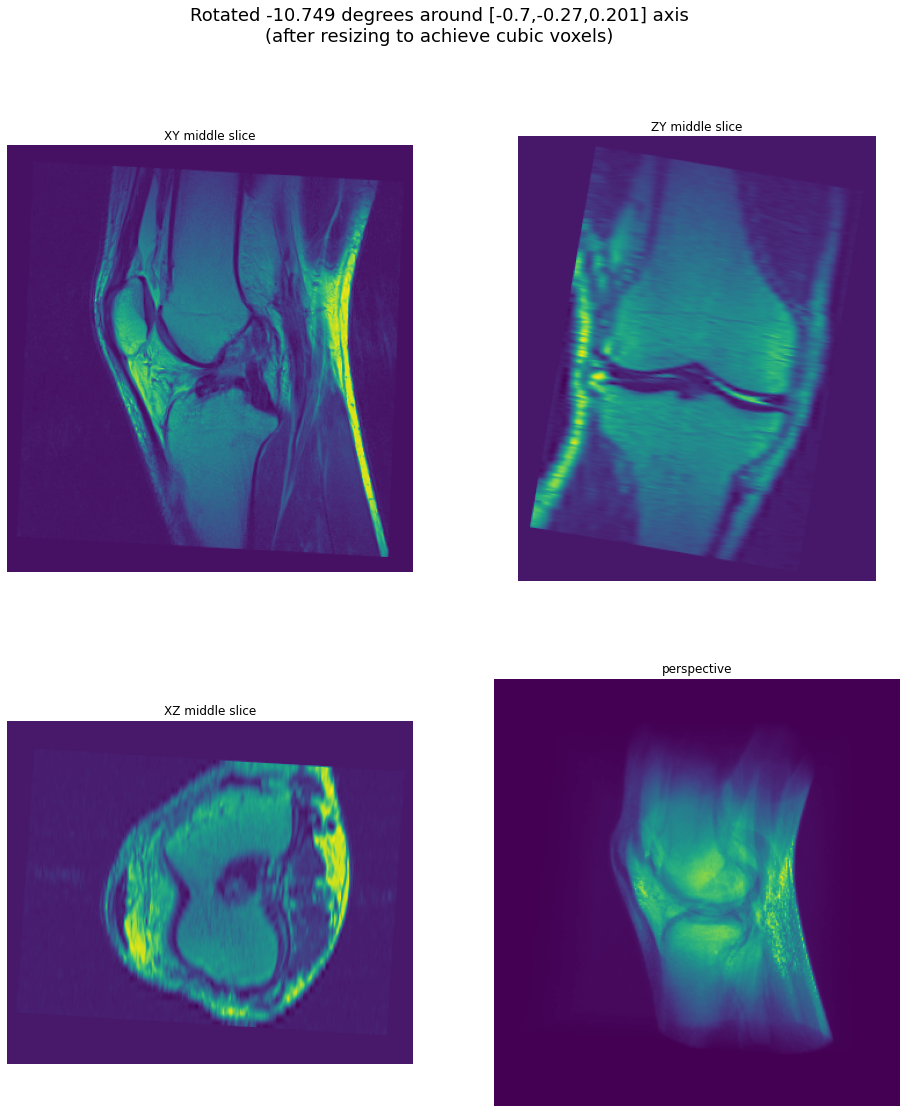

In [17]:
angle = pipe_out[-1].at(0)
axis = pipe_out[-2].at(0).tolist()
draw_volume(pipe_out[2].as_cpu().at(0),
            "Rotated {:.3f} degrees around [{:.3},{:.3},{:.3}] axis".format(angle, axis[0], axis[1], axis[2]) +
            "\n(after resizing to achieve cubic voxels)")

### Result: WarpAffine

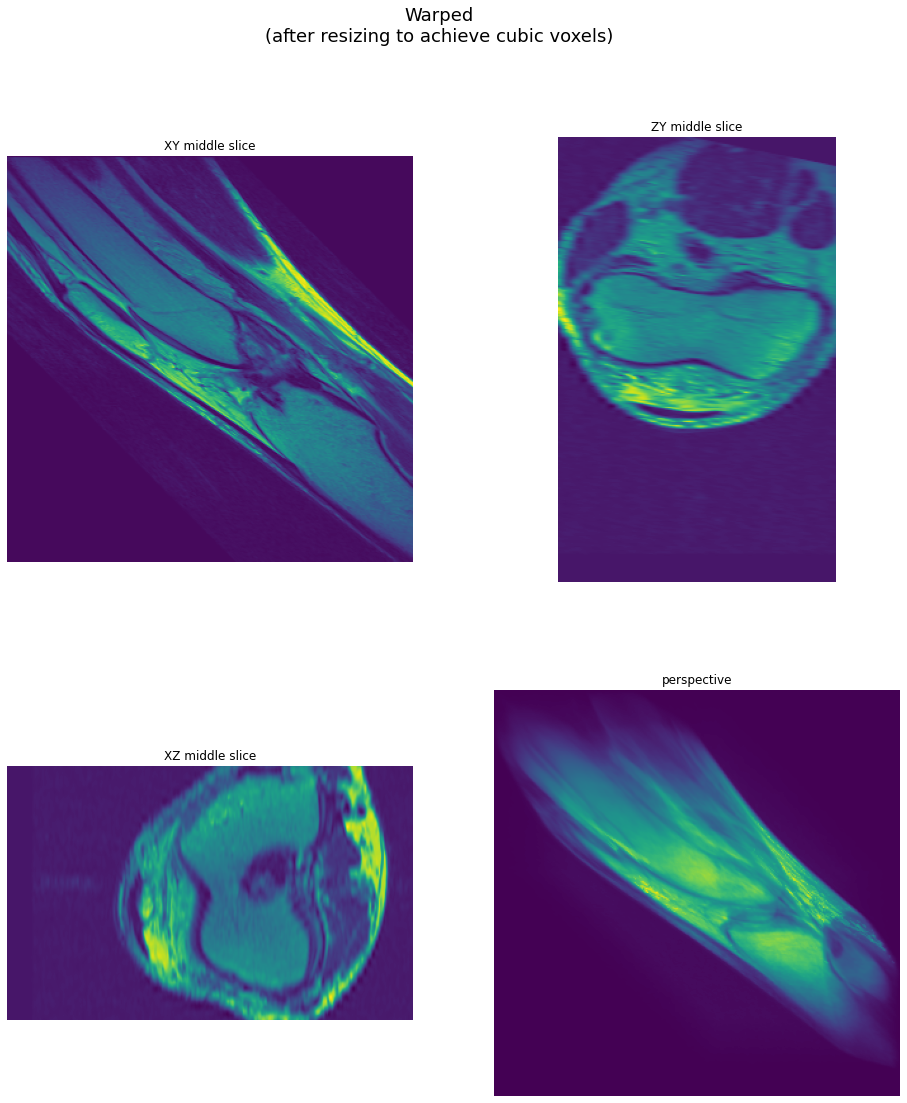

In [18]:
draw_volume(pipe_out[3].as_cpu().at(0), "Warped\n(after resizing to achieve cubic voxels)")